In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [1]:
def load_training_dataset():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]
    )

    # Load training set
    trainset = torchvision.datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=len(trainset), shuffle=True, num_workers=2
    )

    testset = torchvision.datasets.MNIST(
        root="data", train=False, download=True, transform=transform
    )

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2
    )

    dataset_training_images, dataset_training_labels = next(iter(trainloader))

    return dataset_training_images, dataset_training_labels


dataset_training_images, dataset_training_labels = load_training_dataset()

print(dataset_training_images.size())
print(dataset_training_labels.size())


NameError: name 'transforms' is not defined

In [6]:
class MNISTAutoEncoder(torch.nn.Module):
    def __init__(self, feature_space_dimensionality):
        super().__init__()

        self.linear_encoder_1 = torch.nn.Linear(in_features=1 * 28 * 28, out_features=64)
        self.linear_encoder_2 = torch.nn.Linear(in_features=64, out_features=64)
        self.linear_encoder_final = torch.nn.Linear(in_features=64, out_features=feature_space_dimensionality)

        self.linear_decoder_1 = torch.nn.Linear(in_features=feature_space_dimensionality, out_features=64)
        self.linear_decoder_2 = torch.nn.Linear(in_features=64, out_features=64)
        self.linear_decoder_final = torch.nn.Linear(in_features=64, out_features=1 * 28 * 28)      


    def forward(self, tensor_images):
        x = tensor_images.view(-1, 1 * 28 * 28)

        x = self.linear_encoder_1(x)
        x = torch.relu(x)

        x = self.linear_encoder_2(x)
        x = torch.relu(x)

        encoding = self.linear_encoder_final(x)

        x = self.linear_decoder_1(encoding)
        x = torch.relu(x)

        x = self.linear_decoder_2(x)
        x = torch.relu(x)

        return self.linear_decoder_final(x).view(-1, 1, 28, 28)

    def get_encoding(self, tensor_images):
        x = tensor_images.view(-1, 1 * 28 * 28)

        x = self.linear_encoder_1(x)
        x = torch.relu(x)
        
        x = self.linear_encoder_2(x)
        x = torch.relu(x)

        return self.linear_encoder_final(x)


In [8]:
mnist_auto_encoder = MNISTAutoEncoder(feature_space_dimensionality=10)
print(mnist_auto_encoder)

n_batch = 42
random_tensor = torch.randn(size=(n_batch, 1, 28, 28))
print(mnist_auto_encoder(random_tensor).size()) 

MNISTAutoEncoder(
  (linear_encoder_1): Linear(in_features=784, out_features=64, bias=True)
  (linear_encoder_2): Linear(in_features=64, out_features=64, bias=True)
  (linear_encoder_final): Linear(in_features=64, out_features=10, bias=True)
  (linear_decoder_1): Linear(in_features=10, out_features=64, bias=True)
  (linear_decoder_2): Linear(in_features=64, out_features=64, bias=True)
  (linear_decoder_final): Linear(in_features=64, out_features=784, bias=True)
)
torch.Size([42, 1, 28, 28])


In [10]:
mnist_autoencoder = MNISTAutoEncoder(feature_space_dimensionality=10)
optimiser = torch.optim.Adam(mnist_autoencoder.parameters())

In [11]:
# ------------------
# Loss Function
# ------------------

# We are in a Reconstruction-based Problem:
# Given an image, we want to encode it, and decode it to reconstruct the same image
# So we just need to minimise the error of reconstruction.

# Here, we intend to minimise the error of reconstruction between the image given to the autoencoder, 
# and the reconstruction of that image outputted by the autoencoder.

# In the end, we intend to minimise the Mean Squared Error of reconstruction

# In PyTorch, that mean squared error is given by nn.MSELoss().

loss = torch.nn.MSELoss()

In [13]:
def divide_in_batches_32(tensor_dataset):
    number_samples = tensor_dataset.size()[0]

    step = 32

    list_batches_dataset = []
    for index in range(0, number_samples, step):
        new_batch = tensor_dataset[index : index + step]
        list_batches_dataset.append(new_batch)

    return list_batches_dataset


In [14]:
def train_autoencoder_batches(mnist_autoencoder, loss, optimiser, list_batches_images, number_training_steps):
    for _ in range(number_training_steps):

        running_loss = 0.0

        for batch_image in list_batches_images:
            optimiser.zero_grad()

            # Compute Loss
            reconstruction = mnist_autoencoder(batch_image)
            value_loss = loss.forward(input=reconstruction,
                                      target=batch_image)

            value_loss.backward()
            optimiser.step()

            running_loss += value_loss.item()

        running_loss = running_loss / len(list_batches_images)
        print("running loss:", running_loss)

In [15]:
list_batches_images = divide_in_batches_32(dataset_training_images)
list_batch_labels = divide_in_batches_32(dataset_training_labels)

In [16]:
# --------
# training MNISTAutoEncoder with batches
# --------

mnist_autoencoder = MNISTAutoEncoder(feature_space_dimensionality=10)
loss = torch.nn.MSELoss()
optimiser = torch.optim.Adam(mnist_autoencoder.parameters())
train_autoencoder_batches(mnist_autoencoder,
                         loss,
                         optimiser,
                         list_batches_images,
                         number_training_steps=5)

running loss: 0.16339496934016545
running loss: 0.12351098943948746
running loss: 0.11548809401591618
running loss: 0.11019738761583964
running loss: 0.10645707106987636


In [ ]:
class MNISTEncoder(torch.nn.Module):
    def __init__(self, feature_space_dimensionality):
        super().__init__()

        self.linear_encoder_1 = torch.nn.Linear(in_features=1 * 28 * 28, out_features=64)
        self.linear_encoder_2 = torch.nn.Linear(in_features=64, out_features=64)
        self.linear_encoder_final = torch.nn.Linear(in_features=64, out_features=feature_space_dimensionality)


    def forward(self, tensor_images):
        
        # Flattening images
        x = tensor_images.view(-1, 1 * 28 * 28)

        # Encoder --------------------

        # Encoder - Layer 1
        x = self.linear_encoder_1(x)
        x = torch.relu(x)
        
        # Encoder - Layer 2
        x = self.linear_encoder_2(x)
        x = torch.relu(x)

        # Encoder - Final Layer
        x = self.linear_encoder_final(x)
        # Note that there is no activation function here

        return x

In [ ]:
class MNISTDecoder(torch.nn.Module):
    def __init__(self, feature_space_dimensionality):
        super().__init__()

        self.linear_decoder_1 = torch.nn.Linear(in_features=feature_space_dimensionality, out_features=64)
        self.linear_decoder_2 = torch.nn.Linear(in_features=64, out_features=64)
        self.linear_decoder_final = torch.nn.Linear(in_features=64, out_features=1 * 28 * 28) 


    def forward(self, tensor_encoding):
        
        # Decoder - Layer 1
        x = self.linear_decoder_1(tensor_encoding)
        x = torch.relu(x)

        # Decoder - Layer 2
        x = self.linear_decoder_2(x)
        x = torch.relu(x)

        # Decoder - Final Layer
        reconstruction = self.linear_decoder_final(x)


        # Putting reconstruction on the right shape (as original images)
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        return reconstruction

In [ ]:
class MNISTAutoEncoderRefactored(torch.nn.Module):
    def __init__(self, feature_space_dimensionality):
        super().__init__()

        self.encoder = MNISTEncoder(feature_space_dimensionality)
        self.decoder = MNISTDecoder(feature_space_dimensionality)


    def forward(self, tensor_images):
        encoding = self.encoder(tensor_images)

        reconstruction = self.decoder(encoding)

        return reconstruction


    def get_encoding(self, tensor_images):

        encoding = self.encoder(tensor_images)

        return encoding

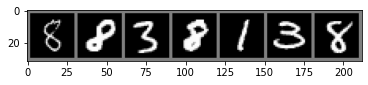

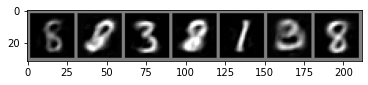

In [17]:
# --------
# Showing reconstruction of an image
# --------

import matplotlib.pyplot as plt
import numpy as np

# Function for showing an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

with torch.no_grad():
    # get some random training images
    images = dataset_training_images[0:7]

    # show images
    imshow(torchvision.utils.make_grid(images))


    # show reconstructions
    reconstructions = mnist_autoencoder(images)
    imshow(torchvision.utils.make_grid(reconstructions))